# Test Systems

Uses REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
path = '../data/nonressystems/Kepler-431/simulation_archives/runs/'

In [3]:
from celmech import Andoyer

def get_k(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    return row

In [4]:
trainpath = '../training_data/nonressystems/Kepler-431/featuresNorbits10000.0Nout80trio/'
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
labels['Z12'] = 0.
labels['Zcom12'] = 0.
labels['Z23'] = 0.
labels['Zcom23'] = 0.
labels['e2'] = 0.
labels['e3'] = 0.

In [5]:
labels.head()

,runstring,instability_time,shadow_instability_time,Stable,k,h,Z12,Zcom12,Z23,Zcom23,e2,e3
0,0000000.bin,7.485924e+01,1.060708e+02,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000001.bin,9.990000e+08,9.990000e+08,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0000002.bin,9.990000e+08,9.990000e+08,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000003.bin,1.648912e+01,1.648912e+01,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0000004.bin,9.990000e+08,9.990000e+08,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
%%time
dasklabels = dd.from_pandas(labels, npartitions=24)
df = dasklabels.apply(get_k, axis=1, meta=labels).compute(scheduler='processes')

CPU times: user 383 ms, sys: 266 ms, total: 649 ms
Wall time: 1.34 s


In [7]:
def pred(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    sim.dt = 0.07*sim.particles[1].P
    row['probstability'] = model.predict(sim, copy=False)
    return row

In [8]:
from spock import StabilityClassifier
model = StabilityClassifier()

# df is a regular pandas dataframe. Calculate how long it takes to evaluate stability on all

In [9]:
%%time
df = df.apply(pred, axis=1)

CPU times: user 3h 44min 30s, sys: 4min 49s, total: 3h 49min 19s
Wall time: 19min 13s


In [10]:
%%time
threshold=0.605
proba = df['probstability'].values
stablemask = df['Stable'] == True
unstablemask = df['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold
sstablemask = df['shadow_instability_time'] > 9.97e8
sunstablemask = df['shadow_instability_time'] < 9.97e8

CPU times: user 68.2 ms, sys: 6 ms, total: 74.2 ms
Wall time: 1.78 ms


In [11]:
stablemask.sum()

1095

In [12]:
unstablemask.sum()

405

# TPR

In [13]:
(stablemask & pstablemask).sum()/stablemask.sum()

0.9680365296803652

# FPR

In [14]:
1-(unstablemask & punstablemask).sum()/unstablemask.sum()

0.07654320987654317

In [15]:
(unstablemask & punstablemask).sum()/unstablemask.sum()

0.9234567901234568

# Fraction that agree

In [16]:
((stablemask & pstablemask).sum() + (unstablemask & punstablemask).sum())/(stablemask.sum() + unstablemask.sum())

0.956

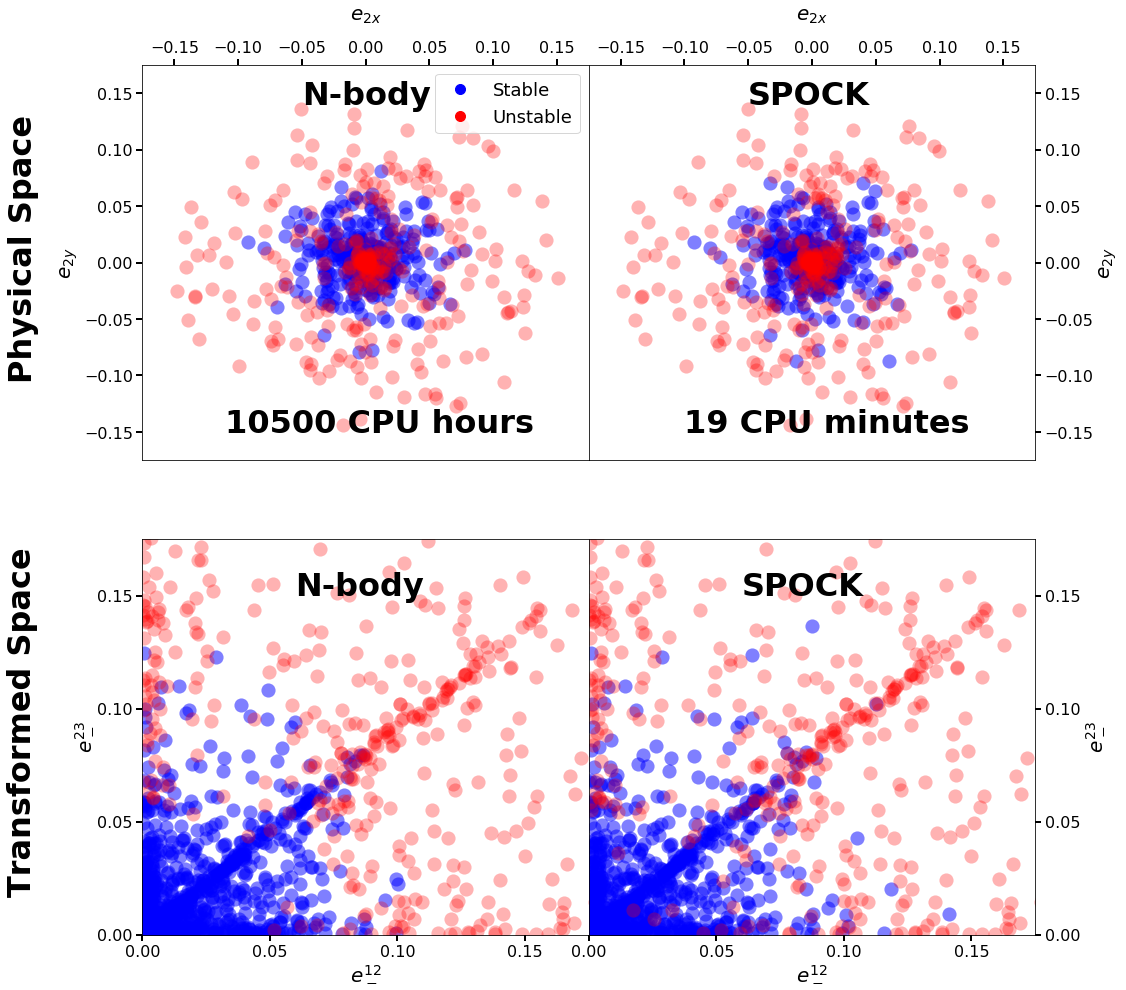

In [17]:
from matplotlib.lines import Line2D

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(wspace=0)

s=200
axarr[0,0].scatter(df["k"][stablemask], df["h"][stablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, rasterized=True)
axarr[0,0].scatter(df["k"][unstablemask], df["h"][unstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, rasterized=True)
axarr[0,1].scatter(df["k"][pstablemask], df["h"][pstablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, rasterized=True)
axarr[0,1].scatter(df["k"][punstablemask], df["h"][punstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, rasterized=True)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.11, -0.15, '10500 CPU hours', weight='bold', size=32, color='black')
axarr[0,1].text(-0.1, -0.15, '19 CPU minutes', weight='bold', size=32, color='black')
axarr[0,0].text(-0.05, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.05, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.28, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.175
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])

legend_elements = [Line2D([0], [0], marker='o', lw=0, c='b', markerfacecolor='b', label='Stable', markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='r', markerfacecolor='r', label='Unstable', markersize=10)]
axarr[0,0].legend(handles=legend_elements, loc='upper right', fontsize=18)


axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()

axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$')
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")

s=200
axarr[1,0].scatter(df["Z12"][stablemask]*np.sqrt(2), df["Z23"][stablemask]*np.sqrt(2), c='b', s=s, lw=0, label='Stable', alpha=0.5, rasterized=True)
axarr[1,0].scatter(df["Z12"][unstablemask]*np.sqrt(2), df["Z23"][unstablemask]*np.sqrt(2), c='r', s=s, lw=0, label='Unstable', alpha=0.3, rasterized=True)
axarr[1,1].scatter(df["Z12"][pstablemask]*np.sqrt(2), df["Z23"][pstablemask]*np.sqrt(2), c='b', s=s, lw=0, label='Stable', alpha=0.5, rasterized=True)
axarr[1,1].scatter(df["Z12"][punstablemask]*np.sqrt(2), df["Z23"][punstablemask]*np.sqrt(2), c='r', s=s, lw=0, label='Unstable', alpha=0.3, rasterized=True)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.06, 0.15, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.06, 0.15, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.053, 0.02, 'Transformed Space', weight='bold', size=32, rotation=90)

axarr[1,0].set_xlim([0, lim])
axarr[1,0].set_ylim([0, lim])
axarr[1,1].set_xlim([0, lim])
axarr[1,1].set_ylim([0, lim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,0].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")

axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')

fig.savefig('kep431.pdf', bbox_inches='tight')

# Nbody

Text(0.5, 0, '$Z_{12}$')

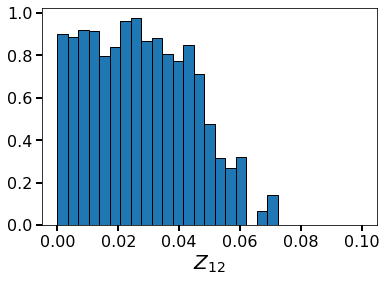

In [18]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z12"][stablemask], bins)
f, edges = np.histogram(df["Z12"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{12}$')

In [19]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
i = interp1d(cum, edges[1:])
print("Z12 < {0:.3f} ({1:.3f} percentile)".format(i(percentile), percentile))

Z12 < 0.045 (0.842 percentile)


# Shadow Nbody

Text(0.5, 0, '$Z_{12}$')

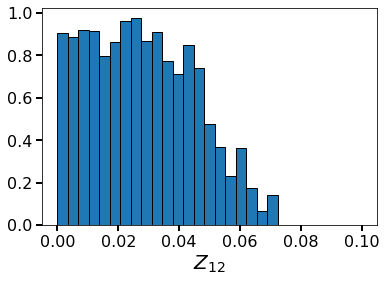

In [20]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z12"][sstablemask], bins)
f, edges = np.histogram(df["Z12"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{12}$')

In [21]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
i = interp1d(cum, edges[1:])
print("Z12 < {0:.4f} ({1:.3f} percentile)".format(i(percentile), percentile))

Z12 < 0.0465 (0.842 percentile)


# SPOCK

Text(0.5, 0, '$Z_{12}$')

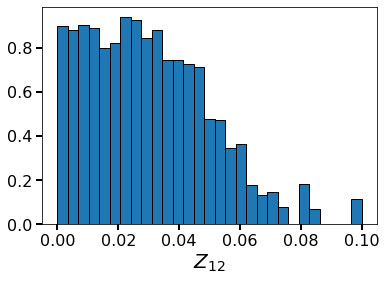

In [22]:
fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z12"][pstablemask], bins)
f, edges = np.histogram(df["Z12"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{12}$')

In [23]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
f = interp1d(cum, edges[1:])
print("Z12 < {0:.3f} ({1:.3f} percentile)".format(f(percentile), percentile))

Z12 < 0.050 (0.842 percentile)


# Nbody

Text(0.5, 0, '$Z_{23}$')

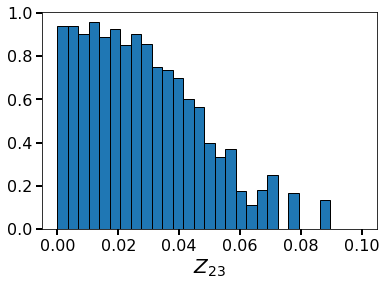

In [24]:
fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z23"][stablemask], bins)
f, edges = np.histogram(df["Z23"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{23}$')

In [25]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
i = interp1d(cum, edges[1:])
print("Z23 < {0:.3f} ({1:.3f} percentile)".format(i(percentile), percentile))

Z23 < 0.048 (0.842 percentile)


# Shadow Nbody

Text(0.5, 0, '$Z_{23}$')

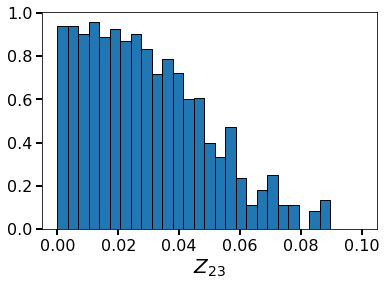

In [26]:
fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z23"][sstablemask], bins)
f, edges = np.histogram(df["Z23"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{23}$')

In [27]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
i = interp1d(cum, edges[1:])
print("Z23 < {0:.3f} ({1:.3f} percentile)".format(i(percentile), percentile))

Z23 < 0.050 (0.842 percentile)


# SPOCK

Text(0.5, 0, '$Z_{23}$')

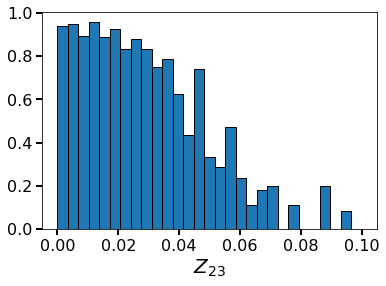

In [28]:
fig, ax = plt.subplots()
Nbins=30
bins = np.linspace(0, 0.1, Nbins)
f_stable, edges = np.histogram(df["Z23"][pstablemask], bins)
f, edges = np.histogram(df["Z23"], bins)
ax.bar(edges[:-1], f_stable/f, width=np.diff(edges), edgecolor="black", align="edge")
ax.set_xlabel(r'$Z_{23}$')

In [29]:
percentile = 0.8415
cum = np.cumsum(f_stable/f)/(f_stable/f).sum()
i = interp1d(cum, edges[1:])
print("Z23 < {0:.3f} ({1:.3f} percentile)".format(i(percentile), percentile))

Z23 < 0.049 (0.842 percentile)
